Everything you need to get the code running + loading of the data.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
from scripts.forest import Forest
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from sklearn.svm import OneClassSVM
import scripts.timeseries as ts
import pandas as pd
import time
import scipy.io as sio
from sklearn import metrics
import rrcf
import h5py
import math
import copy
from typing import List
import numpy as np
from numpy.core import ndarray
from scripts.hg import Histogram
import matplotlib.pyplot as plt
from math import log
#import awkward as awk

In [2]:
dataset = 'thyroid'
trials = 1
run_lof_svm = 1
mat_data = sio.loadmat('../data/'+dataset+'.mat')
X = mat_data['X']
t = X[0,0]
newdir = 'pidtrials/'
if not os.path.exists(newdir):
    os.makedirs(newdir)
file_name = newdir + dataset + '.txt'
File_object = open(file_name,"w")   
print(X.shape)

(7200, 6)


Let's get into forest.fit

In [37]:
## define our parameters!
trials = 1
time_all = np.zeros((trials,1))
precision_all = np.zeros((trials,1))
auc_all = np.zeros((trials,1))
start = time.time()   # to measure time needed ?! :o   cool
t1, _ = np.shape(X)
n_samples = 100
kwargs = {'max_depth': 10, 'n_trees':50,  'max_samples': n_samples, 'max_buckets': 3, 'epsilon': 0.1, 'sample_axis': 1, 
  'threshold': 0}
# probably more buckets needed if bigger dataset / more attributes

In [38]:
def compress(arr, eps):
    min_val = np.min(arr[np.nonzero(arr)])
    max_val = np.max(arr[np.nonzero(arr)])
    k = int(math.log(max_val / min_val) / math.log(1 + eps))
    sp_vals = sorted({min_val * ((1 + eps) ** i) for i in range(k + 1)})
    sp_indices = sorted(set(np.searchsorted(arr, sp_vals)))
    compress_arr = {index: arr[index] for index in sp_indices}
    return compress_arr

class Histogram:

    def __init__(self, val, count, max_buckets, eps):
        self.num = len(val)
        self.max_buckets = max_buckets
        self.val = val
        self.count = count
        self.eps = eps
        self.err, self.b_values = approx_buckets(val, count, max_buckets, eps)

    def __str__(self):
        str_val = ""
        for i in range(self.max_buckets):
            str_val += "Level " + str(i) + ":"
            for b_val in self.b_values[i]:
                a_val, err_a, _, _, _ = self.b_values[i][b_val]
                str_val += " (" + str(a_val) + ", " + str(b_val) + "): " + str(err_a) + ", "
            str_val += "\n"
        return str_val

    def test(self):
        print(str(self))
        for i in range(1, self.max_buckets):
            print(self.compute_buckets(i))
        print("Best Buckets: ")
        print(self.best_split())

    def best_split(self):
        if self.err[0] == 0:
            return 0, 0, []
        err_red = [(self.err[0] - self.err[i]) for i in range(1, self.max_buckets)]
        var_red = np.max(err_red) / self.err[0]
        if var_red < 0:
            print("error: var_red is", var_red)
            var_red = 0
        opt = np.argmax(err_red) + 2  # why +2 and not +1 ???????
        buckets = self.compute_buckets(opt)
        return opt, var_red, buckets[1:]

    def compute_buckets(self, num_buckets):
        buckets = []
        end = self.num - 1
        k = num_buckets - 1
        while end >= 0:
            start = int(self.b_values[k][end][0])
            if start <= end:
                buckets.append(start)
            end = start - 1
            k -= 1
        return np.flip(buckets, axis=0)


def two_split(val, count):
    p_count = np.cumsum(count)
    s_count = p_count[-1] - p_count
    p_sum = np.cumsum(val*count)
    s_sum = p_sum[-1] - p_sum
    scores = (p_sum**2)[:-1]/p_count[:-1] + (s_sum**2)[:-1]/s_count[:-1]
    return scores


def approx_buckets(arr, count, max_buckets, eps):
    """params:
    vals: the array of values
    counts: the array of counts
    max_buckets: the number of buckets
    eps: an approximation parameter
    returns:
     1) an array cur_err[k], which gives the error of the best histogram with k buckets.
     2) a dictionary b_values.
    b_values stores a collection of intervals for each level k where 0 <= k < B. It is indexed by
    the level k and the endpoint b of an interval (a,b) at level k.
    The value is a 4 tuple:
    1) a: start point of the interval
    2) ApxError(b,k) for that point.
    3) sum until b
    4) sum of squares until b
    5) total count until b"""
    err_a = np.zeros(max_buckets) - 1
    cur_err = np.zeros(max_buckets)
    b_values = [{} for _ in range(max_buckets)]
    cur_sum = 0
    cur_sq = 0
    cur_pts = 0
    for j in range(len(arr)):
        cur_sum += arr[j] * count[j]
        cur_sq += (arr[j] ** 2) * count[j]
        cur_pts += count[j]
        cur_err[0] = cur_sq - cur_sum**2/cur_pts
        if cur_err[0] > (1 + eps) * err_a[0]:
            err_a[0] = cur_err[0]
        else:
            del b_values[0][j - 1]
        b_values[0][j] = (0, cur_err[0], cur_sum, cur_sq, cur_pts)
        for k in range(1, max_buckets):
            cur_err[k] = cur_err[k - 1]
            a_val = j + 1
            for b_val in b_values[k - 1].keys():
                if b_val < j:
                    _, b_err, b_sum, b_sq, b_pts = b_values[k - 1][b_val]
                    tmp_error = b_err + cur_sq - b_sq - (cur_sum - b_sum) ** 2 / (cur_pts - b_pts)
                    if tmp_error < cur_err[k]:
                        cur_err[k] = tmp_error
                        a_val = b_val + 1
            b_values[k][j] = (a_val, cur_err[k], cur_sum, cur_sq, cur_pts)
            if cur_err[k] > (1 + eps) * err_a[k]:
                err_a[k] = cur_err[k]
            else:
                del b_values[k][j - 1]
   # print(type(b_values))

    return cur_err, b_values

In [39]:
to_print = False

class Forest:
    """This creates a forest of trees, given the following list of parameters:
    1) n_trees: the number of trees
    2) max_depth: the depth of the trees
    3) max_samples: number of samples per tree
    4) max_buckets: maximum number of buckets used by the histogram
    5) epsilon: accuracy of the histogram"""
    dim = ...  # type: int
    size = ...  # type: int
    points = ...  # type: ndarray
    start = ...  # type: ndarray
    end = ...  # type: ndarray

    def __init__(self, **kwargs):
        self.n_trees = kwargs['n_trees']
        self.max_depth = kwargs['max_depth']
        self.max_samples = kwargs['max_samples']
        self.max_buckets = kwargs['max_buckets']
        self.epsilon = kwargs['epsilon']
        self.sample_axis = kwargs['sample_axis']
        self.threshold = kwargs['threshold']
        self.tree = []
        self.dimensionchosen = []   ## this is new
        self.split_dict = {}  ## new 
        self.counter_split = 0  ## new
        # np.random.seed(seed = 17)
        self.n_leaves = np.zeros(self.n_trees)

    def fit(self, pts):
        self.points = pts
        self.dim, self.size = np.shape(self.points)
        if int(self.sample_axis*self.dim) == 0:
            print("sample_axis is too low")
            return
        self.start = np.zeros(self.dim)
        self.end = np.zeros(self.dim)
        for axis in range(self.dim):
            val = np.unique(np.array(self.points[axis]))
            if len(val) <= 1:
                print("No entropy in dimension :", axis)
                return
            self.start[axis] = (3 * val[0] - val[1]) / 2
            self.end[axis] = (3 * val[-1] - val[-2]) / 2
        k_args = {'depth': 0, 'forest': self}
        max_sample_size = np.min((self.size, self.max_depth*200))
        sample = np.random.choice(self.size, max_sample_size, replace=False)

    
        for i in range(self.n_trees):
            
            ###new
            self.counter_split = i
            self.split_dict[self.counter_split] = {}
            for j in range(self.dim):
                self.split_dict[self.counter_split][j] = []
            ### ok
            
            k_args['indices'] = np.random.choice(self.size, self.max_samples, replace=False)
            root_node = Node(**k_args)
            root_node.compute_density(sample)
            self.tree.append(root_node)
            self.n_leaves[i] = root_node.compute_leaf_num()

           
    def plt_scores(self, pts):
        _, n_pts = np.shape(pts)
        n_show = int(2 * self.n_trees / 3)
        scores = np.zeros((self.n_trees, n_pts))  # need to do this streaming
        indices = [i for i in range(n_pts)]
        for i in range(self.n_trees):
            self.tree[i].compute_split(pts, indices, scores[i])
        for i in range(n_pts):
            plt.plot(np.sort(scores[:, i])[:n_show])
            plt.show()

    def predict(self, pts, err=0.1, pct=50):
        _, n_pts = np.shape(pts)
        scores = np.zeros((self.n_trees, n_pts))  # need to do this streaming
        indices = [i for i in range(n_pts)]
        for i in range(self.n_trees):
            self.tree[i].compute_split(pts, indices, scores[i])
        n_err = int(err * n_pts)
        min_score = np.percentile(scores, pct, axis=0)
        top_indices = np.argsort(min_score)[:n_err]
        anom_pts = {}
        anom_scores = {}
        anom_pct = {}
        for i in range(n_err):
            anom_pts[top_indices[i]] = pts[:, top_indices[i]]
            anom_scores[top_indices[i]] = scores[:, top_indices[i]]
            anom_pct[top_indices[i]] = min_score[top_indices[i]]
        return top_indices, anom_pts, anom_scores, anom_pct, min_score
    
    def predict_depth(self, pts, err=0.1, pct=50):
        _, n_pts = np.shape(pts)
        scores = np.zeros((self.n_trees, n_pts))  # need to do this streaming
        indices = [i for i in range(n_pts)]
        for i in range(self.n_trees):
            self.tree[i].compute_depth(pts, indices, scores[i])
        n_err = int(err * n_pts)
        min_score = np.percentile(scores, pct, axis=0)
        top_indices = np.argsort(min_score)[:n_err]
        anom_pts = {}
        anom_scores = {}
        anom_pct = {}
        for i in range(n_err):
            anom_pts[top_indices[i]] = pts[:, top_indices[i]]
            anom_scores[top_indices[i]] = scores[:, top_indices[i]]
            anom_pct[top_indices[i]] = min_score[top_indices[i]]
        return top_indices, anom_pts, anom_scores, anom_pct, min_score
    
    def find_min_cube(self, pts, n_err=1, pct1=50, pct2=50):
        _, n_pts = np.shape(pts)
        scores = np.zeros((self.n_trees, n_pts))  # need to do this streaming
        indices = [i for i in range(n_pts)]
        for i in range(self.n_trees):
            self.tree[i].compute_split(pts, indices, scores[i])
        min_score = np.percentile(scores, pct1, axis=0)
        top_indices = np.argsort(min_score)[:n_err]
        sort_trees = np.argsort(scores, axis=0)
        min_tree = sort_trees[int(self.n_trees*pct2/100.0)]
        boxes = []
        for i in range(0,n_err):
            print('----')
            best_tree = min_tree[top_indices[i]]
            boxes.append( self.tree[best_tree].compute_box(pts[:,top_indices[i]]) )
            # boxes = self.tree[best_tree].compute_box(pts[:,top_indices[i]])
        return top_indices, boxes


class PointSet:
    def __init__(self, node, indices):
        self.node = node
        self.indices = indices
        self.val = []
        self.count = []
        self.gap = []
        for axis in range(self.node.forest.dim):
            val, count = np.unique(np.array(self.node.forest.points[axis, self.indices]), return_counts=True)
            self.val.append(val)
            self.count.append(count)
            if len(val) <= 1:
                gap = [0]
            else:
                gap = np.zeros(len(val))
                gap[0] = (val[0] + val[1]) / 2 - self.node.cube.start[axis]
                gap[-1] = self.node.cube.end[axis] - (val[-1] + val[-2]) / 2
                for i in range(1, len(val) - 1):
                    gap[i] = (val[i + 1] - val[i - 1]) / 2
            self.gap.append(gap)


class Cube:
    def __init__(self, node, start, end):
        assert isinstance(node, Node)   # this just checks if there is a node, right??
        self.node = node
        self.child = []
        self.start = start
        self.end = end
        self.dim = len(start)
        self.split_axis = -1
        self.split_vals = []
        self.vol = 0
        for i in range(self.dim): # in the case of the thyroid, this dimension is 6
            #print(self.end[i] - self.start[i])
            self.vol += log(self.end[i] - self.start[i])  # here, why are we adding to the volume and not mupltiplying ? bc of the log ?
        #print('testing')

    def filter_indices(self, indices):
        in_lb = self.node.forest.points[:, indices] >= self.start.reshape(self.dim, 1)
        in_ub = self.node.forest.points[:, indices] < self.end.reshape(self.dim, 1)
        return [indices[i] for i in range(len(indices)) if in_lb[:, i].all() and in_ub[:, i].all()]

    def split_indices(self, pts, indices):
        n_child = len(self.child)
        if n_child == 0:
            return indices
        n_arr = len(indices)
        if n_arr == 0:
            return [[] for _ in range(n_child)]
        s_arr = pts[self.split_axis]
        s_start = self.start[self.split_axis]
        s_end = self.end[self.split_axis]
        index_split = [[] for _ in range(n_child)]
        index_split[0] = [ind for ind in indices if ((s_arr[ind] >= s_start) and (s_arr[ind] < self.split_vals[0]))]
        index_split[-1] = [ind for ind in indices if ((s_arr[ind] >= self.split_vals[-1]) and (s_arr[ind] < s_end))]
        for k in range(1, n_child - 1):
            index_split[k] = [ind for ind in indices if (s_arr[ind] >= self.split_vals[k - 1]) and
                              (s_arr[ind] < self.split_vals[k])]
        return index_split

class Node:

    def __init__(self, depth, forest, **kwargs):
        self.depth = depth
        self.forest = forest

        if self.depth == 0:
            self.id_string = [0]
            self.cube = Cube(self, self.forest.start, self.forest.end)
            self.point_set = PointSet(self, kwargs['indices'])
        else:
            self.id_string = kwargs['id']
            self.cube = Cube(self, kwargs['start'], kwargs['end'])
            self.point_set = PointSet(self, self.cube.filter_indices(kwargs['indices']))
        self.density = -1
        self.child = []
        if (self.depth < self.forest.max_depth) and (len(self.point_set.indices) > 1):
            self.find_split()

    def find_split(self): # here we find out which axis gives us what variance reduction ..
        imp_axis = [axis for axis in range(self.cube.dim) if len(self.point_set.val[axis]) > 1]
        #print(f"important axis length {len(imp_axis)}")
        if not imp_axis:
            return
        max_axes = min(len(imp_axis), int(self.forest.sample_axis * self.cube.dim))
        s_axes = np.random.choice(imp_axis, max_axes, replace=False)
        buckets = {}
        var_red = {}
        for axis in s_axes:
            hist = Histogram(self.point_set.gap[axis] / self.point_set.count[axis], self.point_set.count[axis],
                             self.forest.max_buckets, self.forest.epsilon)
            _, var_red[axis], buckets[axis] = hist.best_split()
        #print(f"var_red{var_red[0]}, buckets {buckets[0]}")
        if np.max(list(var_red.values())) <= self.forest.threshold:
            return
        split_axis = np.random.choice(s_axes, p=list(var_red.values()) / np.sum(list(var_red.values())))
        #print(f"s_axes {s_axes}, p {list(var_red.values()) / np.sum(list(var_red.values()))} ")
        #print(f"split_axis {split_axis}")
        # here the choice is based on probability?
        self.cube.split_axis = split_axis
        self.cube.split_vals = [(self.point_set.val[split_axis][i - 1] + self.point_set.val[split_axis][i]) / 2 for i in
                                buckets[split_axis]]  
        # okay but i think truly THIS is where the actual splitting is happening.... right ???????????????
        # split_axis a good variable to keep track of bc.. thats where it's starting to split :) 
        # but the choice seems to be based on probability rather than a set criteria.. am i wrong?
        # so the p input tells the probability distribution of it :)) so the random choice is based on a pdf instead of assuming its uniform
        self.forest.dimensionchosen.append(split_axis)  ## new
        #print(f"split_axis {split_axis}, split_vals {self.cube.split_vals}")
        ## here to store it in the dictionary
        self.forest.split_dict[self.forest.counter_split][split_axis].append(self.cube.split_vals)  ## new
        ##
        for i in range(len(self.cube.split_vals) + 1):
            new_start = np.array(self.cube.start)
            new_end = np.array(self.cube.end)
            if 0 < i < len(self.cube.split_vals):
                new_start[split_axis] = self.cube.split_vals[i - 1]
                new_end[split_axis] = self.cube.split_vals[i]
            elif i == 0:
                new_end[split_axis] = self.cube.split_vals[0]
            else:  # i == len(self.cube.split_vals)
                new_start[split_axis] = self.cube.split_vals[-1]
            new_id = copy.deepcopy(self.id_string)
            new_id.append(i)
            kwargs = {'start': new_start, 'end': new_end}
            kwargs.update({'indices': self.point_set.indices, 'id': new_id})
            child_node = Node(self.depth + 1, self.forest, **kwargs) # recursive Node
            self.child.append(child_node)
            self.cube.child.append(child_node.cube)

    def compute_density(self, indices):
        num = len(indices)
        if num == 0:
            self.density = 0
            self.child = []
            self.cube.child = []
            self.cube.split_axis = -1
            return
        self.density = log(num) - self.cube.vol
        if self.child:
            index_split = self.cube.split_indices(self.forest.points, indices)
            for i in range(len(self.child)):
                self.child[i].compute_density(index_split[i])

    def compute_leaf_num(self):
        if self.child:
            leaves = 0
            for i in range(len(self.child)):
                leaves += self.child[i].compute_leaf_num()
            return leaves
        else:
            return 1

    def compute_split(self, pts, indices, scores):
        if self.child:
            index_split = self.cube.split_indices(pts, indices)
            for i in range(len(self.child)):
                if len(index_split[i]) > 0:
                    self.child[i].compute_split(pts, index_split[i], scores)
        else:
            scores[indices] = self.density
            
    def compute_box(self, pts):
        if self.child:
            n_child = len(self.child)
            s_arr = pts[self.cube.split_axis]
            print('splitting on axis '+str(self.cube.split_axis)) 
            s_start = self.cube.start[self.cube.split_axis]
            s_end = self.cube.end[self.cube.split_axis]
            if ((s_arr >= s_start) and (s_arr < self.cube.split_vals[0])):
                #print('splitting on axis '+str(self.cube.split_axis)) 
                return(self.child[0].compute_box(pts))
            elif ((s_arr >= self.cube.split_vals[-1]) and (s_arr < s_end)):
                #print('splitting on axis '+str(self.cube.split_axis)) 
                return(self.child[-1].compute_box(pts))
            else:
                for k in range(1, n_child - 1):
                    if (s_arr >= self.cube.split_vals[k - 1]) and (s_arr < self.cube.split_vals[k]):
                        #print(str(k)+'splitting on axis '+str(self.cube.split_axis)+'\n') 
                        return(self.child[k].compute_box(pts))
        else:
            return self.cube
        
    def compute_depth(self, pts, indices, scores):
        if self.child:
            index_split = self.cube.split_indices(pts, indices)
            for i in range(len(self.child)):
                if len(index_split[i]) > 0:
                    self.child[i].compute_depth(pts, index_split[i], scores)
        else:
            scores[indices] = self.depth    

    def __str__(self):
        str_val = "Id: " + str(self.id_string) + "\n"
        str_val += "Boundary: "
        for i in range(self.cube.dim):
            str_val += " [" + str(self.cube.start[i]) + ", " + str(self.cube.end[i]) + "]"
            if i < self.cube.dim - 1:
                str_val += " x"
            else:
                str_val += "\n"
        str_val += "Points:\n " + str(np.transpose(self.point_set.points)) + "\n"
        str_val += "Indices: " + str(self.point_set.indices) + "\n"
        return str_val

    def print_node(self):
        print_list = [self]
        while print_list:
            node = print_list.pop(0)
            print(str(node))
            print_list.extend(node.child)

In [40]:
forest = Forest(**kwargs)

In [42]:
output = forest.fit(np.transpose(X))

this is the histogram of splits of dimension 0 and its length 322


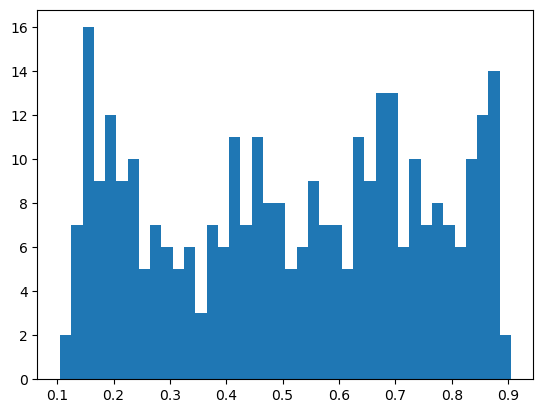

this is the histogram of splits of dimension 1 and its length 397


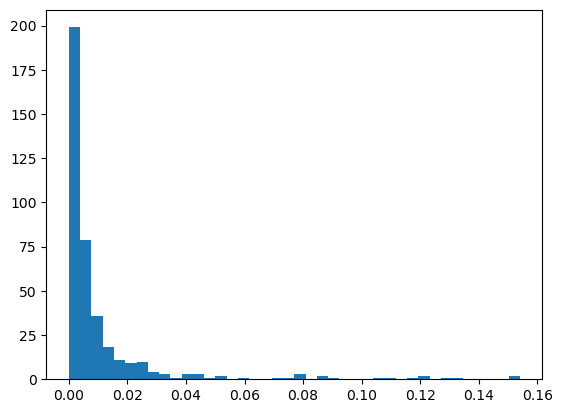

this is the histogram of splits of dimension 2 and its length 373


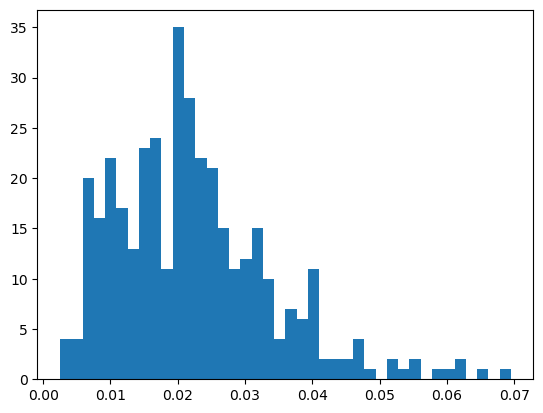

this is the histogram of splits of dimension 3 and its length 377


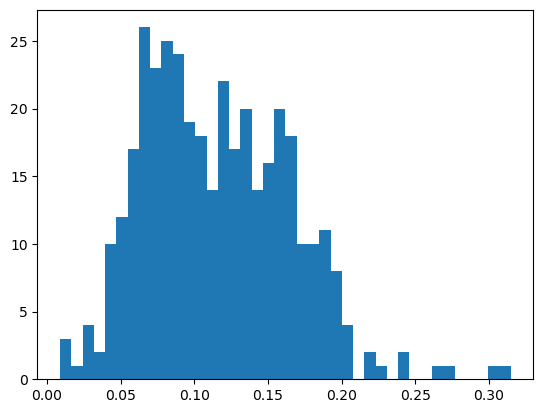

this is the histogram of splits of dimension 4 and its length 408


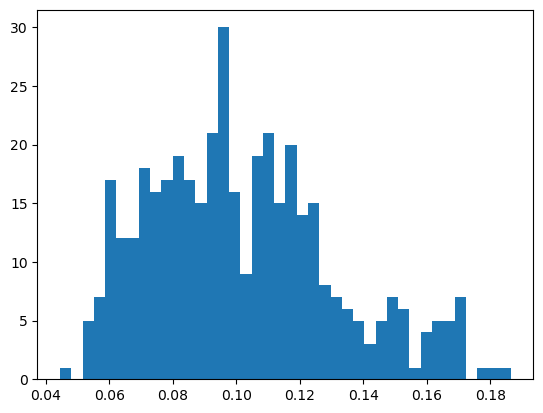

this is the histogram of splits of dimension 5 and its length 385


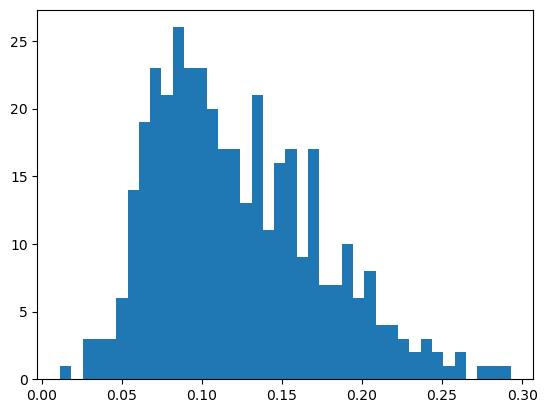

In [51]:
splits_of_dict = forest.split_dict
ll = []
for jj in range(forest.dim):
    ll = []
    for i in range(forest.n_trees):
        ll += [item for sublist in splits_of_dict[i][jj] for item in sublist]
    print(f"this is the histogram of splits of dimension {jj} and its length {len(ll)}")
    plt.hist(ll, bins = 40)
    plt.show()

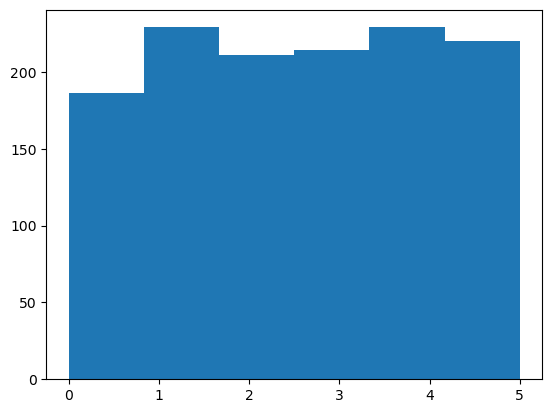

In [49]:
plt.hist(forest.dimensionchosen, bins= forest.dim)
plt.show()
pass

In [ ]:
dont run more than here

In [ ]:
# experimental area of the notebook

In [ ]:
emptydict = {}

In [ ]:
for i in range(0,5):
    emptydict[i] = []

In [ ]:
emptydict[1].append([23,1,34,23])
#emptydict[4].append([6,2,4,1,34,2,32,41,2413,4,3])

In [ ]:
Input: myDict = {}
           myDict["key1"] = [1, 2]                          # Adding list as value
           myDict["key2"] = ["Geeks", "For", "Geeks"] 
Output: {'key2': ['Geeks', 'For', 'Geeks'], 'key1': [1, 2]} 
Explanation: In the output, we have a dictionary of lists.

In [ ]:
emptydict

In [ ]:
emptydict[2].append([23,1,34,23])


In [ ]:
emptydict[4].append([2])

In [ ]:
original_list = emptydict[1]


In [ ]:
flat_list = [item for sublist in original_list for item in sublist]

In [ ]:
print(flat_list)

In [ ]:
emptydict

In [ ]:
>>> d = {}
>>> d['dict1'] = {}
>>> 
>>> d['dict1']['innerkey2'] = 'value2'
>>> d
{'dict1': {'innerkey': 'value', 'innerkey2': 'value2'}}

In [ ]:
d = {}

In [ ]:
d['dict1'] = {}

In [ ]:
d['dict1']['innerkey'] = 'value'

In [ ]:
d

In [ ]:
d['dict1']['innerkey'] = 'value'

In [ ]:
d

In [ ]:
d['dict1']['innerkey2'] = 'value2'

In [ ]:
d